# Nora param

Env: `phd_v3_ml` or `phd_ml_v0`

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
# sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
sys.path.insert(1, '/home/lalandmi/Dropbox/Thèse/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()


# ML
from tensorflow import keras

3.7.8 | packaged by conda-forge | (default, Jul 31 2020, 02:25:08) 
[GCC 7.5.0]


/home/lalandmi/miniconda3/envs/phd_ml_v0/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/lalandmi/miniconda3/envs/phd_ml_v0/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/lalandmi/miniconda3/envs/phd_ml_v0/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/lalandmi/miniconda3/en

## Try with few tiles (1°x1°)

In [2]:
path = '/home/lalandmi/Dropbox/data/HMA_UCLA_Reanalysis/'

### Load sd, swe and sca

In [3]:
ds = xr.open_mfdataset('/home/lalandmi/Dropbox/data/HMA_UCLA_Reanalysis/5000001147190/*/HMA_SR_D_v01_N*E*_agg_16_WY1999_00_SD_POST.nc')
# ds = xr.open_dataset(path+'5000001147190/210524848/HMA_SR_D_v01_N36_0E74_0_agg_16_WY1999_00_SD_POST.nc')

# Add time coordinates (time starts 1rst october)
ds = ds.assign_coords(Day=pd.date_range(start='1999-10-01', periods=ds.Day.size, freq='D'))
sd = ds.SD_Post.isel(Stats=0).rename({'Longitude': 'lon', 'Latitude': 'lat', 'Day': 'time'}).transpose("time", "lat", "lon")

In [4]:
ds = xr.open_mfdataset('/home/lalandmi/Dropbox/data/HMA_UCLA_Reanalysis/5000001147190/*/HMA_SR_D_v01_N*E*_agg_16_WY1999_00_SWE_SCA_POST.nc')
# ds = xr.open_dataset(path+'5000001147190/210524848/HMA_SR_D_v01_N36_0E74_0_agg_16_WY1999_00_SWE_SCA_POST.nc')

ds = ds.assign_coords(Day=pd.date_range(start='1999-10-01', periods=ds.Day.size, freq='D'))

swe = ds.SWE_Post.isel(Stats=0).rename({'Longitude': 'lon', 'Latitude': 'lat', 'Day': 'time'}).transpose("time", "lat", "lon")
scf = ds.SCA_Post.isel(Stats=0).rename({'Longitude': 'lon', 'Latitude': 'lat', 'Day': 'time'}).transpose("time", "lat", "lon")

### Coarsen values to 0.2° (~20km)

In [5]:
sd_20km = sd.coarsen(lat=45, lon=45).mean().load()
swe_20km = swe.coarsen(lat=45, lon=45).mean().load()
scf_20km = scf.coarsen(lat=45, lon=45).mean().load()

## Load topo 

In [6]:
latlim, lonlim = u.get_domain_HMA()
root_data_path = '/home/lalandmi/Dropbox/data/' # local
latlim_ext, lonlim_ext = slice(latlim.start-5, latlim.stop+5), slice(lonlim.start-5, lonlim.stop+5)

ds = xr.open_dataset(root_data_path+'GMTED2010/GMTED2010_15n060_0250deg.nc').drop_dims('nbounds').swap_dims(
    {'nlat': 'latitude', 'nlon': 'longitude'}).drop({'nlat', 'nlon'}).rename(
    {'latitude': 'lat', 'longitude': 'lon'}).sel(lat=latlim_ext, lon=lonlim_ext)
elevation = ds.elevation
elevation_std = ds.elevation_stddev

In [7]:
elevation_subset = elevation.sel(lon=slice(sd.lon.min(),sd.lon.max()), lat=slice(sd.lat.min(),sd.lat.max()))
elevation_std_subset = elevation_std.sel(lon=slice(sd.lon.min(),sd.lon.max()), lat=slice(sd.lat.min(),sd.lat.max()))

## Compute mu_n and xi_n

In [8]:
R_earth = 6371e3

def compute_dy(delta_deg, R_earth):
    return np.deg2rad(delta_deg)*R_earth # delta latitude in km

def compute_dx(delta_deg, R_earth, lat):
    return np.deg2rad(delta_deg)*R_earth*np.cos(np.deg2rad(lat)) # delta longitude in km (weighted by cos(lat))

# Compute xi_n

xi_n = elevation.copy().astype('float32')
mu_n = elevation.copy().astype('float32')

for i_lat, lat in enumerate(elevation.lat.values):
    print('ilat = ' + str(i_lat) + ' / ' + str(elevation.lat.size))
    # Ignore the first/last points as I won't need them anyway
    if (i_lat == 0) or (i_lat == elevation.lat.size-1):
        xi_n[i_lat] = np.nan
    else:
        dy_deg = (elevation.lat[i_lat+1] - elevation.lat[i_lat-1]).values.item(0)

        for i_lon, lon in enumerate(elevation.lon.values):
            # Ignore the first/last points as I won't need them anyway
            if (i_lon == 0) or (i_lon == elevation.lon.size-1):
                xi_n[i_lat, i_lon] = np.nan
            else:
                dx_deg = (elevation.lon[i_lon+1] - elevation.lon[i_lon-1]).values.item(0)

                dy = compute_dy(dy_deg, R_earth)
                dx = compute_dx(dx_deg, R_earth, lat)

                dz_x = (elevation.isel(lat=i_lat, lon=i_lon+1) - elevation.isel(lat=i_lat, lon=i_lon-1)).values.item(0)
                dz_y = (elevation.isel(lon=i_lon, lat=i_lat+1) - elevation.isel(lon=i_lon, lat=i_lat-1)).values.item(0)

                mu = np.sqrt(
                    np.abs( (dz_x/dx)**2 + (dz_y/dy)**2 ) / 2 
                )

                mu_n[i_lat, i_lon] = mu
                xi_n[i_lat, i_lon] = np.sqrt(2) * elevation_std.sel(lat=lat, lon=lon).values.item(0) / (mu + np.finfo(np.float32).eps)

ilat = 0 / 140
ilat = 1 / 140
ilat = 2 / 140
ilat = 3 / 140
ilat = 4 / 140
ilat = 5 / 140
ilat = 6 / 140
ilat = 7 / 140
ilat = 8 / 140
ilat = 9 / 140
ilat = 10 / 140
ilat = 11 / 140
ilat = 12 / 140
ilat = 13 / 140
ilat = 14 / 140
ilat = 15 / 140
ilat = 16 / 140
ilat = 17 / 140
ilat = 18 / 140
ilat = 19 / 140
ilat = 20 / 140
ilat = 21 / 140
ilat = 22 / 140
ilat = 23 / 140
ilat = 24 / 140
ilat = 25 / 140
ilat = 26 / 140
ilat = 27 / 140
ilat = 28 / 140
ilat = 29 / 140
ilat = 30 / 140
ilat = 31 / 140
ilat = 32 / 140
ilat = 33 / 140
ilat = 34 / 140
ilat = 35 / 140
ilat = 36 / 140
ilat = 37 / 140
ilat = 38 / 140
ilat = 39 / 140
ilat = 40 / 140
ilat = 41 / 140
ilat = 42 / 140
ilat = 43 / 140
ilat = 44 / 140
ilat = 45 / 140
ilat = 46 / 140
ilat = 47 / 140
ilat = 48 / 140
ilat = 49 / 140
ilat = 50 / 140
ilat = 51 / 140
ilat = 52 / 140
ilat = 53 / 140
ilat = 54 / 140
ilat = 55 / 140
ilat = 56 / 140
ilat = 57 / 140
ilat = 58 / 140
ilat = 59 / 140
ilat = 60 / 140
ilat = 61 / 140
ilat = 62 / 140
il

In [10]:
plot.rc['cartopy.autoextent'] = True

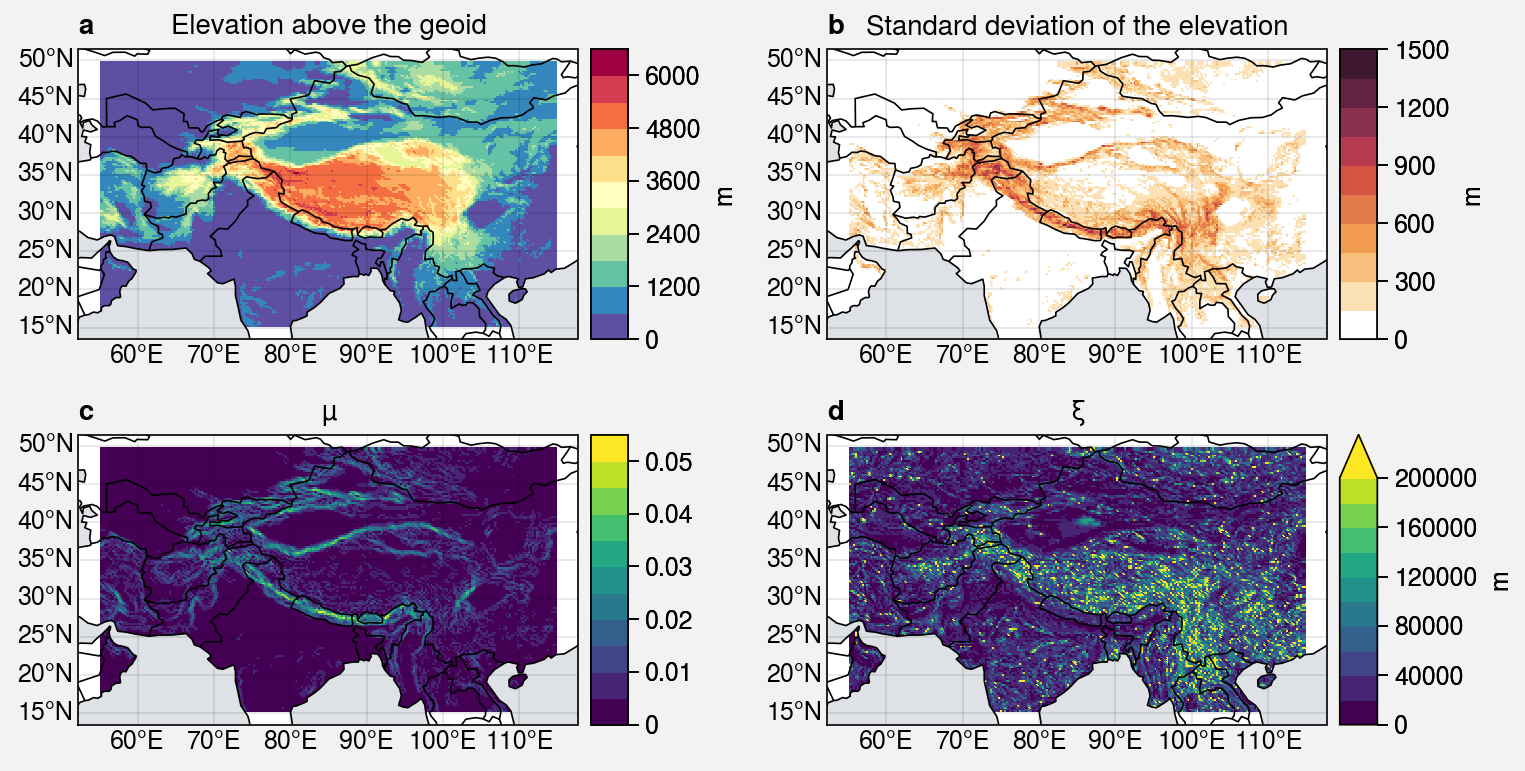

In [27]:
f, axs = plot.subplots(proj='cyl', ncols=2, nrows=2)

# Elevation
m0 = axs[0].pcolormesh(elevation[1:-1,1:-1], cmap='Spectral_r', vmin=0)
axs[0].colorbar(m0, label='m')

# STD
m1 = axs[1].pcolormesh(elevation_std[1:-1,1:-1])
axs[1].colorbar(m1, label='m')

# Elevation
m2 = axs[2].pcolormesh(mu_n[1:-1,1:-1], cmap='viridis')
axs[2].colorbar(m2)

# STD
m3 = axs[3].pcolormesh(xi_n[1:-1,1:-1], cmap='viridis', vmax=200000, extend='max')
axs[3].colorbar(m3, label='m')

for ax, title in zip(axs, [
    'Elevation above the geoid', 'Standard deviation of the elevation',
    'µ', 'ξ',
]):
    ax.format(title=title)

# Format
axs.format(
    # Grids, labels and limits
    labels=True, lonlines=10, latlines=5, 
#     latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    abc=True,
)


# Save
f.save('img/Nora_param_topo_parameters.jpg')

In [65]:
def Nora(SWE, Ld_n, xi_n):
    """
        Compute the snow cover fraction from Helbig et al. (2021) 
        parameterization. (https://tc.copernicus.org/articles/15/615/2021/)
        
        Parameters
        ----------
        Ld_n : Coarse-grid cell size (m)
        xi_n : terrain correlation length (cf. Helbig et al, 2021)
            
    """

    
    # Lower snow depth limit which is taken from swe_threshold = 2 mm 
    # converted using the standard_density = 350 kg/m^3 to snow depth_threshold
    snowdepth_threshold = 0.005714286
    
    # Calculate topo terms needed for standard deviation of snow depth 
    sd_snowdepth1 = np.exp(-1 / (Ld_n/xi_n)**2)
    sd_snowdepth3 = slopemu_n**(0.3193*(Ld_n**0.1034))
    
    for i_time in swe_regrid.time.size:
        
    
    return 

In [78]:
2/350

0.005714285714285714

In [ ]:

  # Calculate topo terms needed for standard deviation of snow depth 
  sd_snowdepth1 = exp(-1 / (Ld_n/xi_n)**2)
  sd_snowdepth3 = slopemu_n**(0.3193*(Ld_n**0.1034))

  # Merge current SWEtmp with SWEtmp history from past 14 days
  SWEbuffer(1) = SWEtmp
  SWEbuffer(2:15) = swehist_n(:)
  snowdepthbuffer(1) = snowdepth_n
  snowdepthbuffer(2:15) = snowdepthhist_n(:)

  # Update 14 days history
  swehist_n(1:14) = SWEbuffer(1:14)
  snowdepthhist_n(1:14) = snowdepthbuffer(1:14)

  # Calculate snowdepthmin_buffer, snowdepthmax_buffer, snowdepthmin_recent 
  # Find indices of global min and max in SWEbuffer
  iabsmax = maxloc(SWEbuffer,DIM=1)
  iabsmin = minloc(SWEbuffer,DIM=1)

  # Find index of recent min in SWEbuffer
  # Calculate diff vector of SWEBuffer
  do iloop = 1, 14
    diffSWEbuffer = SWEbuffer(iloop+1)-SWEbuffer(iloop)
    if (diffSWEbuffer(iloop) > 0.5) then
      EXIT
    end if
  end do
  irecentmin = minloc(SWEbuffer(1:iloop),DIM=1)

  # Use indices to determine snow depth amounts
  snowdepthmin_buffer = snowdepthbuffer(iabsmin)
  snowdepthmax_buffer = snowdepthbuffer(iabsmax)
  snowdepthmin_recent = snowdepthbuffer(irecentmin)

  # Compute storage of new snow on old snow in snowdepthbuffer 
  dsnowdepth = snowdepth_n - snowdepthmin_buffer
  if (dsnowdepth < 0) then
    dsnowdepth = 0
  end if

  # Compute dswemax in SWEbuffer 
  dsnowdepthmax = snowdepthmax_buffer - snowdepthmin_buffer
  if (dsnowdepthmax < 0) then
    dsnowdepthmax = 0
  end if

  # Don't accept dsnowdepthmax to be larger then dsnowdepth, otherwise larger fnsnow values
  if (dsnowdepthmax < dsnowdepth) then
    dsnowdepthmax = dsnowdepth
  end if

  # Compute storage of recent new snow on old snow in SWEbuffer
  dsnowdepth_recent = snowdepth_n - snowdepthmin_recent
  if (dsnowdepth_recent < 0) then
    dsnowdepth_recent = 0
  end if

  # Set swemax and swemin equal to zero if no snow, same with corresponding snow depth values 
  if (SWEtmp == 0) then
    swemax_n = 0
    swemin_n = 0
    snowdepthmax_n = 0
    snowdepthmin_n = 0
  end if

  # Set swemax and swemin equal to SWEtmp if maximum, store also snowdepthmax and snowdepthmin of those time steps 
  if (SWEtmp >= swemax_n) then
    swemax_n       = SWEtmp
    swemin_n       = SWEtmp
    snowdepthmax_n = snowdepth_n
    snowdepthmin_n = snowdepth_n
  end if

  # Set swemin equal SWEtmp if smaller than swemin, same with corresponding snow depth value 
  if (SWEtmp < swemax_n .and. SWEtmp  < swemin_n) then
    swemin_n = SWEtmp
    snowdepthmin_n = snowdepth_n
  end if

  !!# Start calculating fSCA
  # Initial guess of fSCAs 
  fsnow_season       = 0
  fsnow_nsnow        = 0
  fsnow_nsnow_recent = 0

  !!# Seasonal fSCA, using formulas of Helbig et al.,2015 and Egli and Jonas, 2009
  # Calculate standard deviation as in Helbig et al., 2015, 2021
  sd_snowdepth2 = snowdepthmax_n**(0.5330*(Ld_n**0.0389))
  sd_snowdepth0 = sd_snowdepth1 * sd_snowdepth2 * sd_snowdepth3
  # Calculate standard deviation as in Egli and Jonas, 2009 for completely flat grid cells  
  if (.not.(slopemu_n > epsilon(0.0))) then
    sd_snowdepth0 = snowdepthmax_n**0.84
  end if
  # Calculate fSCA
  if (snowdepthmax_n > 0) then
    fsnow_season = tanh(1.3 * snowdepthmin_n / sd_snowdepth0)
  end if

  !!# Calculate CV
  coeff_vari = sd_snowdepth0 / snowdepthmax_n

  !!# New snow fSCA based on dswe of last 14 days
  # Calculate standard deviation of dhs as in Egli and Jonas, 2009
  sd_snowdepth0_dhs = dsnowdepthmax**0.84
  # Calculate fSCA of new snow of last 14 days
  if (dsnowdepthmax > 0) then
    fsnow_nsnow = tanh(1.3 * dsnowdepth / sd_snowdepth0_dhs)
  end if

  fsnow_nsnow_14days = fsnow_nsnow

  !!# Recent new snow fSCA based on dswe_recent since last minimum
  # Calculate standard deviation of dsnowdepth_recent as in Egli and Jonas, 2009
  sd_snowdepth0_dhs_recent = dsnowdepth_recent**0.84
  # Calculate fSCA of recent new snow with recent dsnowdepth
  if (dsnowdepth_recent > 0) then
    fsnow_nsnow_recent = tanh(1.3 * dsnowdepth_recent / sd_snowdepth0_dhs_recent)
  end if

  !!# Take maximum between the two new snow fSCA, similar to taking the maximum of all three fSCA at the end
  fsnow_nsnow = max(fsnow_nsnow,fsnow_nsnow_recent)

  !!# If snow amounts are too low, set fSCA to zero 
  if (snowdepthmin_n < snowdepth_threshold) then
    fsnow_season = 0
  end if
  if (dsnowdepth < snowdepth_threshold) then
    fsnow_nsnow = 0
  end if

  !!# Use the largest of the two fSCA estimates
  fsnow_n = max(fsnow_season,fsnow_nsnow)

  if ( snowdepth_n < epsilon(0.0) ) then
     fsnow_n = 0
  else
    fsnow_n = min(fsnow_n, 1.)
  end if
